# Postulación a NeuralWorks
**Data Science Challenge**

En el siguiente Notebook se presenta el desarrollo del análisis y respuestas al desafío.

**Felipe Uribe Pizarro**
<br>
09/01/2023

## Preparación
Se importan librerías y se cargan los datos desde el archivo .csv

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb

In [2]:
df_raw = pd.read_csv('dataset_SCL.csv', low_memory=False)
df = df_raw.copy(deep=True)
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


De la muestra del DataFrame cargado, se observan sólo columnas categóricas, a excepción de las dos columnas de fecha. Se le da el formato correspondiente a las columnas.

In [3]:
date_vars = ['Fecha-I', 'Fecha-O']

for column in df.columns:
    if column in date_vars:
        df[column] = pd.to_datetime(df[column])
    else:
        df[column] = df[column].astype('category')

df.dtypes

Fecha-I      datetime64[ns]
Vlo-I              category
Ori-I              category
Des-I              category
Emp-I              category
Fecha-O      datetime64[ns]
Vlo-O              category
Ori-O              category
Des-O              category
Emp-O              category
DIA                category
MES                category
AÑO                category
DIANOM             category
TIPOVUELO          category
OPERA              category
SIGLAORI           category
SIGLADES           category
dtype: object

A continuación, se realiza una inspección rápida de los datos.

In [4]:
df.describe(include='all',datetime_is_numeric=True)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
count,68206,68206,68206,68206,68206,68206,68205,68206,68206,68206,68206.0,68206.0,68206.0,68206,68206,68206,68206,68206
unique,NaN,584,1,64,30,NaN,861,1,63,32,31.0,12.0,2.0,7,2,23,1,62
top,NaN,174,SCEL,SCFA,LAN,NaN,174,SCEL,SCFA,LAN,20.0,12.0,2017.0,Viernes,N,Grupo LATAM,Santiago,Buenos Aires
freq,NaN,686,68206,5787,37611,NaN,649,68206,5786,20988,2290.0,6356.0,68204.0,10292,36966,40892,68206,6335
mean,2017-07-05 12:11:25.320059648,NaN,NaN,NaN,NaN,2017-07-05 12:20:31.971380992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2017-01-01 00:15:00,NaN,NaN,NaN,NaN,2017-01-01 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2017-03-31 12:41:15,NaN,NaN,NaN,NaN,2017-03-31 12:51:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2017-07-10 05:30:00,NaN,NaN,NaN,NaN,2017-07-10 05:37:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2017-10-08 11:18:45,NaN,NaN,NaN,NaN,2017-10-08 11:19:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,2017-12-31 23:55:00,NaN,NaN,NaN,NaN,2018-01-01 00:12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Se observa lo siguiente:
- Sólo falta un dato en la columna Vlo-O. Todas las demás columnas tienen 68206 datos, por lo que no tienen faltantes.
- Todos los datos corresponden a vuelos programados durante el 2017, con origen Santiago.
- Des-I no necesariamente coincide con Des-O, ya que existen distintos valores únicos. Esto aplica también para Vlo-I/Vlo-O y Emp-I/Emp-O.
- Existen menos valores únicos de OPERA que de Emp-I/Emp-O, por lo que cada operador puede tener más de un código de empresa.
<br>

A continuación, se verifican los destinos que no coinciden y las empresas por operador.

In [60]:
df[df['Des-I'].astype(str)!=df['Des-O'].astype(str)]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,temporada_alta,dif_min,atraso_15,periodo_dia
1397,2017-01-17 19:20:00,25,SCEL,SCTE,SKU,2017-01-17 19:46:00,25,SCEL,SCQP,SKU,...,2017,Martes,N,Sky Airline,Santiago,Temuco,1.0,26,1,noche
7290,2017-02-15 06:25:00,11,SCEL,SCTE,SKU,2017-02-15 06:25:00,11,SCEL,SCQP,SKU,...,2017,Miercoles,N,Sky Airline,Santiago,Temuco,1.0,0,0,mañana
7520,2017-02-27 06:40:00,71,SCEL,SCIE,SKU,2017-02-27 09:07:00,71,SCEL,SCQP,SKU,...,2017,Lunes,N,Sky Airline,Santiago,Temuco,1.0,147,1,mañana
8456,2017-02-15 06:10:00,57,SCEL,SCTE,LAN,2017-02-15 06:12:00,57,SCEL,SCQP,LAN,...,2017,Miercoles,N,Grupo LATAM,Santiago,Temuco,1.0,2,0,mañana
12787,2017-03-18 06:25:00,11,SCEL,SCTE,SKU,2017-03-18 06:29:00,11,SCEL,SCQP,SKU,...,2017,Sabado,N,Sky Airline,Santiago,Temuco,0.0,4,0,mañana
12823,2017-03-22 12:50:00,17,SCEL,SCBA,SKU,2017-03-22 12:48:00,17,SCEL,SCTE,SKU,...,2017,Miercoles,N,Sky Airline,Santiago,Puerto Montt,0.0,-2,0,tarde
16169,2017-03-13 23:20:00,532,SCEL,KJFK,LAN,2017-03-14 01:35:00,1346,SCEL,KMIA,LAN,...,2017,Martes,I,Grupo LATAM,Santiago,Miami,0.0,135,1,noche
16937,2017-03-22 17:00:00,1446,SCEL,SEGU,LAN,2017-03-22 17:11:00,1361,SCEL,SABE,LAN,...,2017,Miercoles,I,Grupo LATAM,Santiago,Buenos Aires,0.0,11,0,tarde
18293,2017-04-14 18:40:00,25,SCEL,SCTE,SKU,2017-04-14 18:48:00,25,SCEL,SCQP,SKU,...,2017,Viernes,N,Sky Airline,Santiago,Temuco,0.0,8,0,tarde
20444,2017-04-14 22:00:00,289,SCEL,SCTE,LAN,2017-04-14 22:01:00,289,SCEL,SCCI,LXP,...,2017,Viernes,N,Grupo LATAM,Santiago,Punta Arenas,0.0,1,0,noche


In [54]:
np.sort(pd.unique(df['OPERA'].astype(str)+'-'+df['Emp-I'].astype(str)+'-'+df['Emp-O'].astype(str)))

array(['Aerolineas Argentinas-ARG-ARG', 'Aerolineas Argentinas-ARG-AUT',
       'Aeromexico-AMX-AMX', 'Air Canada-ACA-ACA', 'Air France-AFR-AFR',
       'Alitalia-AZA-AZA', 'American Airlines-AAL-AAL', 'Austral-AUT-ARG',
       'Austral-AUT-AUT', 'Avianca-AVA-AVA', 'Avianca-AVA-LRC',
       'Avianca-AVA-TPU', 'British Airways-BAW-BAW', 'Copa Air-CMP-CMP',
       'Delta Air-DAL-DAL', 'Gol Trans-GLO-GLO', 'Grupo LATAM-DSM-DSM',
       'Grupo LATAM-LAN-DSM', 'Grupo LATAM-LAN-LAN',
       'Grupo LATAM-LAN-LNE', 'Grupo LATAM-LAN-LPE',
       'Grupo LATAM-LAN-LXP', 'Grupo LATAM-LAP-LAP',
       'Grupo LATAM-LNE-LNE', 'Grupo LATAM-LPE-LPE',
       'Grupo LATAM-LXP-LXP', 'Grupo LATAM-TAM-LAP',
       'Grupo LATAM-TAM-TAM', 'Iberia-IBE-IBE', 'JetSmart SPA-JAT-JAT',
       'K.L.M.-KLM-KLM', 'Lacsa-LRC-LRC', 'Latin American Wings-JMR-JMR',
       'Latin American Wings-LAW-48O', 'Latin American Wings-LAW-56R',
       'Latin American Wings-LAW-JMR', 'Oceanair Linhas Aereas-ONE-ONE',
       'Plus Ul

Tras la verificación, se observa:
- Sólo 28 vuelos cambiaron su destino. Esto se se podría deber a alguna emergencia o excepción mayor.
- SIGLADES corresponde a la ciudad del aeropuerto Des-O. Por ejemplo, la fila 62651 tenía destino original Sydney, pero aterrizó en Melbourne.
- Se confirma que cada operador puede tener más de un código de empresa.

## Pregunta 1
**¿Cómo se distribuyen los datos? ¿Qué te llama la atención o cuál es tu conclusión sobre esto?**
<br>

Para responder la pregunta, se procede a graficar la cuenta de observaciones por cada categoría. Se define una función de utilidad y se comienza con las categorías temporales.

In [78]:
def percentage_above_bar_relative_to_xgroup(ax, font_size):
    all_heights = [[p.get_height() for p in bars] for bars in ax.containers]
    for bars in ax.containers:
        for i, p in enumerate(bars):
            total = sum(all_heights[0])
            percentage = f'{(100 * p.get_height() / total) :.1f}%'
            ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), size=font_size, ha='center', va='bottom')


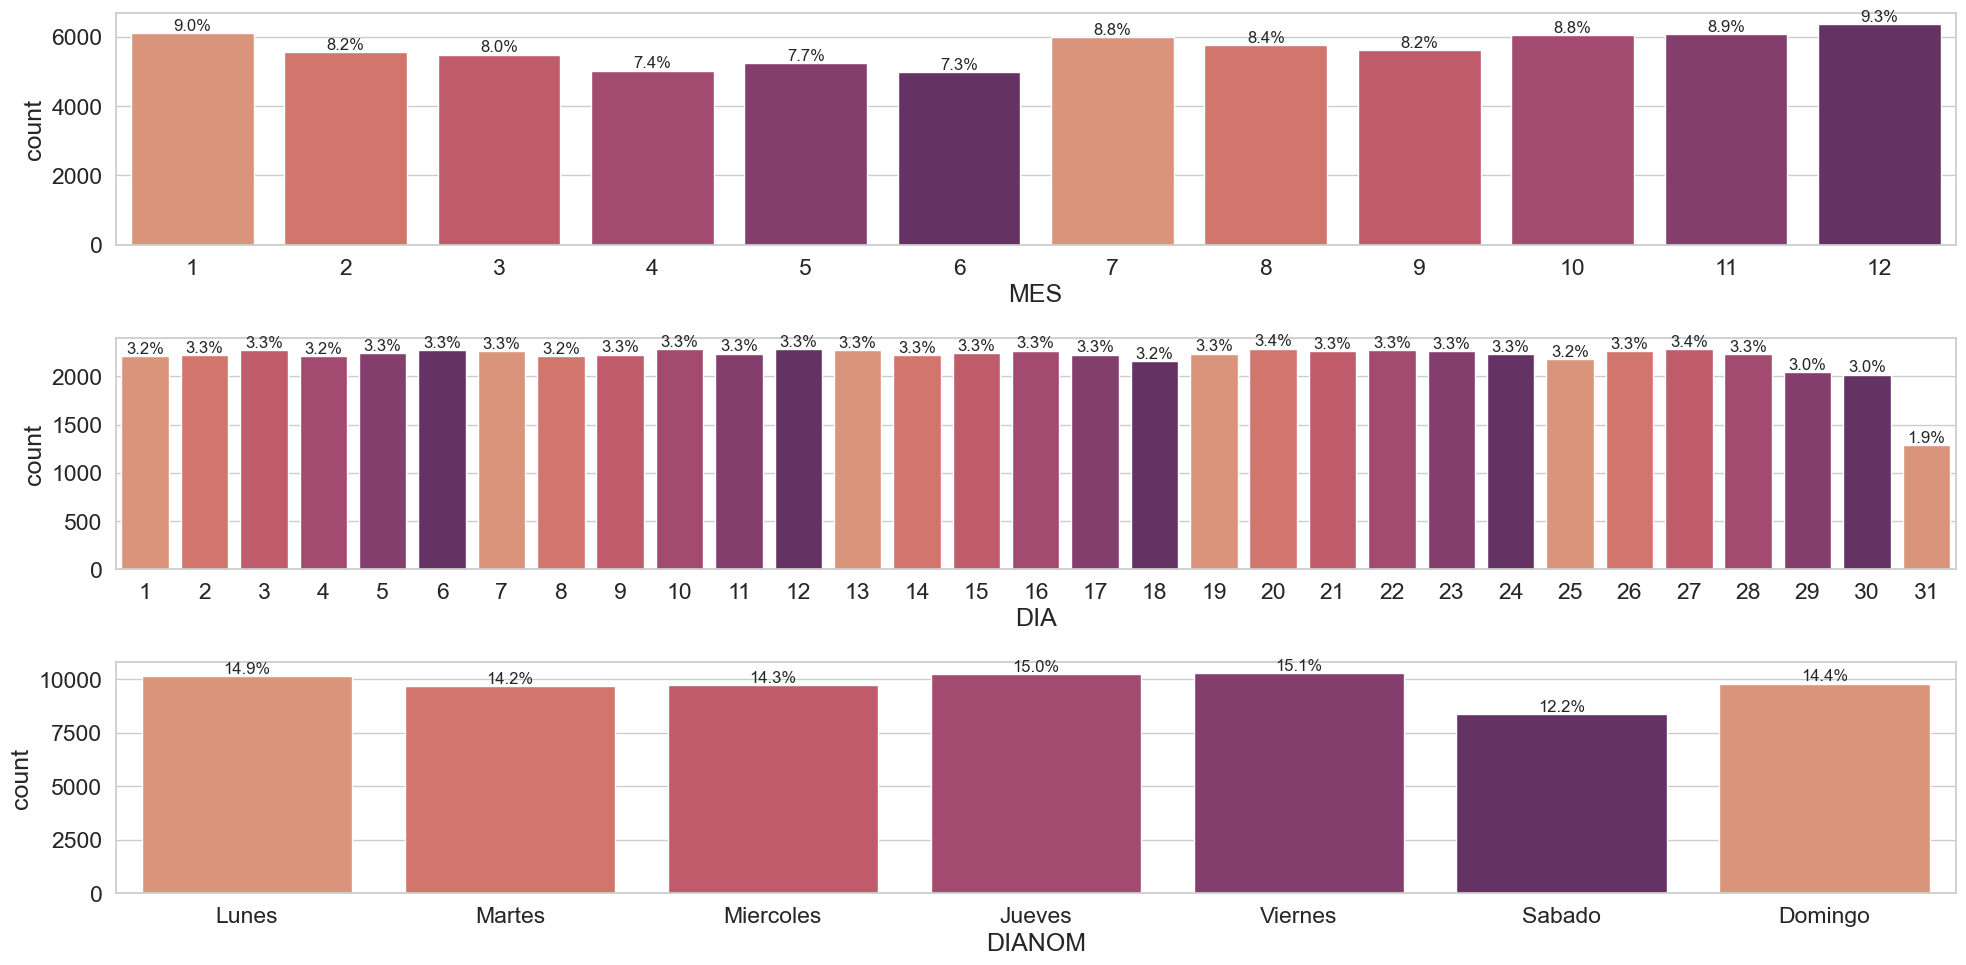

In [79]:
sns.set(rc={'figure.figsize':(20,10)})
sns.set_theme(style="whitegrid", font_scale=1.5)

date_categorical = ['MES','DIA','DIANOM']

plt.figure()
i = 0
for date_cat in date_categorical:
    plt.subplot(len(date_categorical), 1, 1 + i)
    if date_cat == 'DIANOM':
        order = ['Lunes','Martes','Miercoles','Jueves','Viernes','Sabado','Domingo']
        ax = sns.countplot(data=df, x=date_cat,palette = sns.color_palette("flare"), order = order)
    else: ax = sns.countplot(data=df, x=date_cat,palette = sns.color_palette("flare"))
    percentage_above_bar_relative_to_xgroup(ax,12)
    i += 1
plt.tight_layout()

A grandes rasgos se observa una distribución aproximadamente uniforme, salvo por:
- Una baja de cantidad de vuelos durante el Q2.
- Una ligera baja en los últimos días del mes (29, 30). Lógicamente, el día 31 posee considerablemente menos observaciones al no estar presente en todos los meses.
- Una baja en los días Sábado.

Se continua con las categorías de las aerolíneas (empresas/operadores).

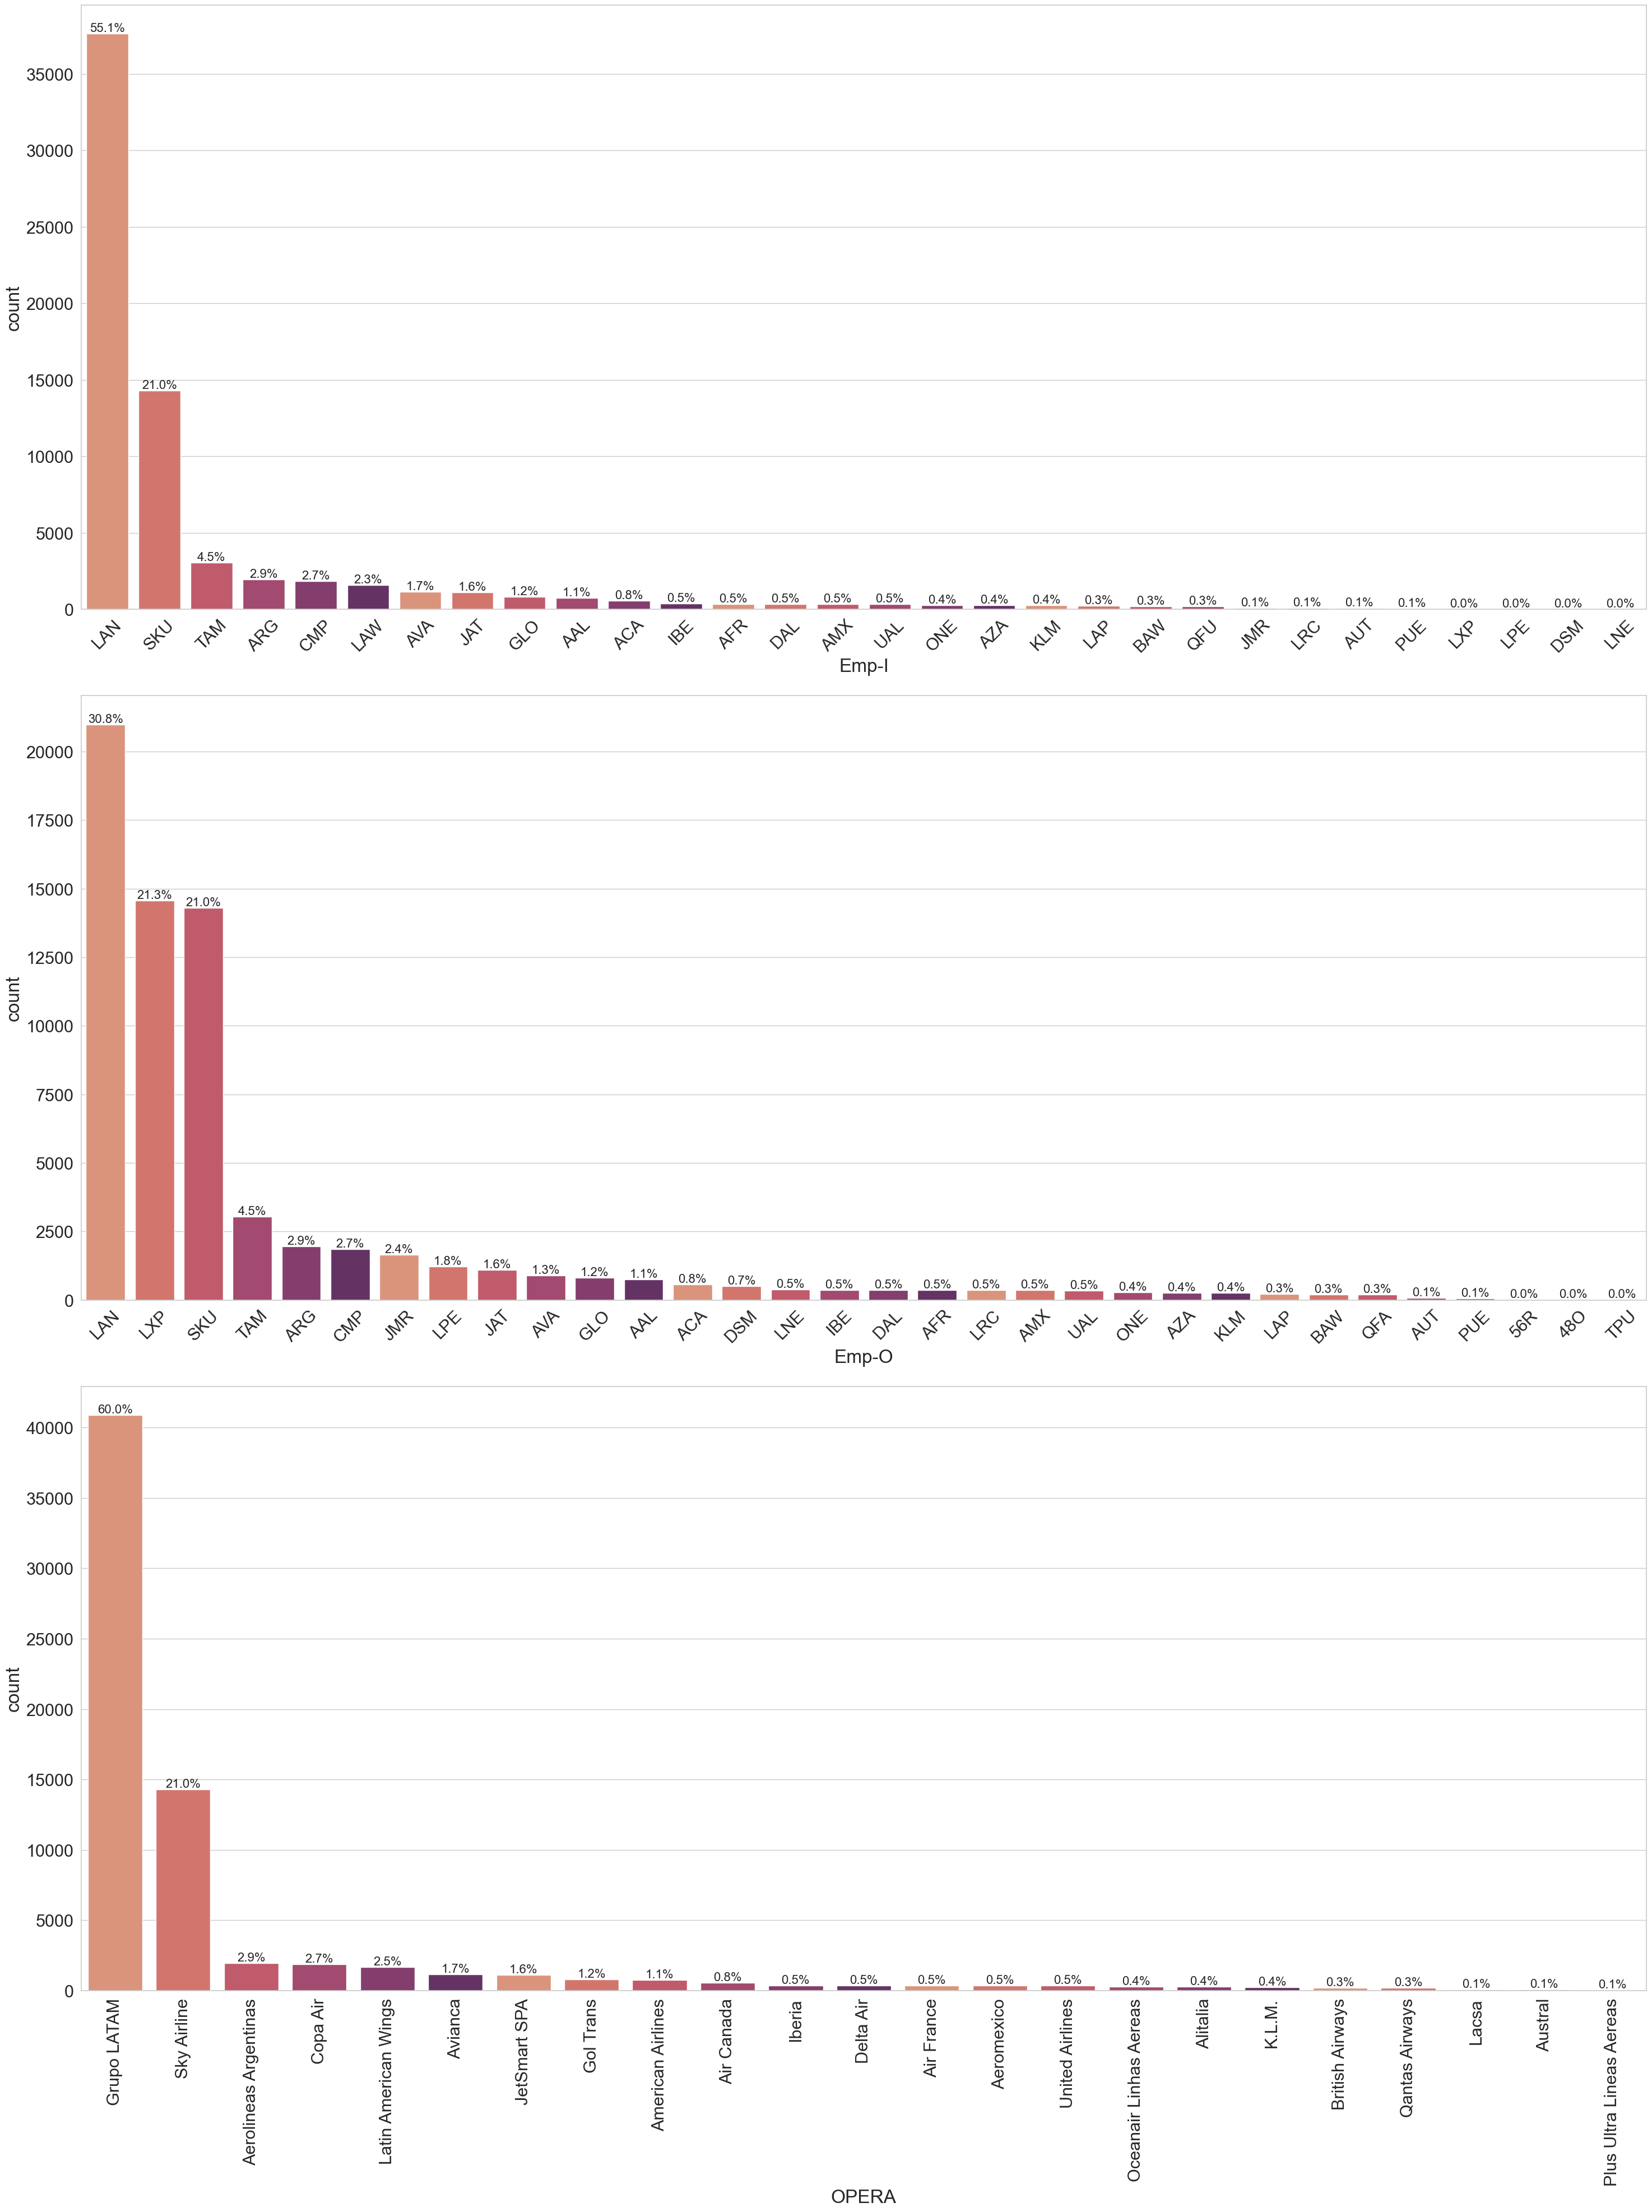

In [80]:
sns.set(rc={'figure.figsize':(30,40)})
sns.set_theme(style="whitegrid", font_scale=2)

categorical_vars = ['Emp-I','Emp-O','OPERA']
plt.figure()
i = 0
for cat in categorical_vars:
    plt.subplot(len(categorical_vars), 1, 1 + i)
    ax = sns.countplot(data=df, x=cat,palette = sns.color_palette("flare"),order = df[cat].value_counts().index)
    if cat == 'OPERA': r=90
    else: r = 45
    percentage_above_bar_relative_to_xgroup(ax,16)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=r)
    i += 1
plt.tight_layout()

Sobre la distribución, se concluye que:
- Pocas aerolíneas (empresas/operadores) concentran la gran mayoría de los vuelos (Latam y Sky).
- Contrastando Emp-I con Emp-O, se observan 'traspasos' de vuelos entre empresas del mismo operador (ejemplo LAN-LXP).

Finalmente, se grafican las variables relacionadas a los destinos.

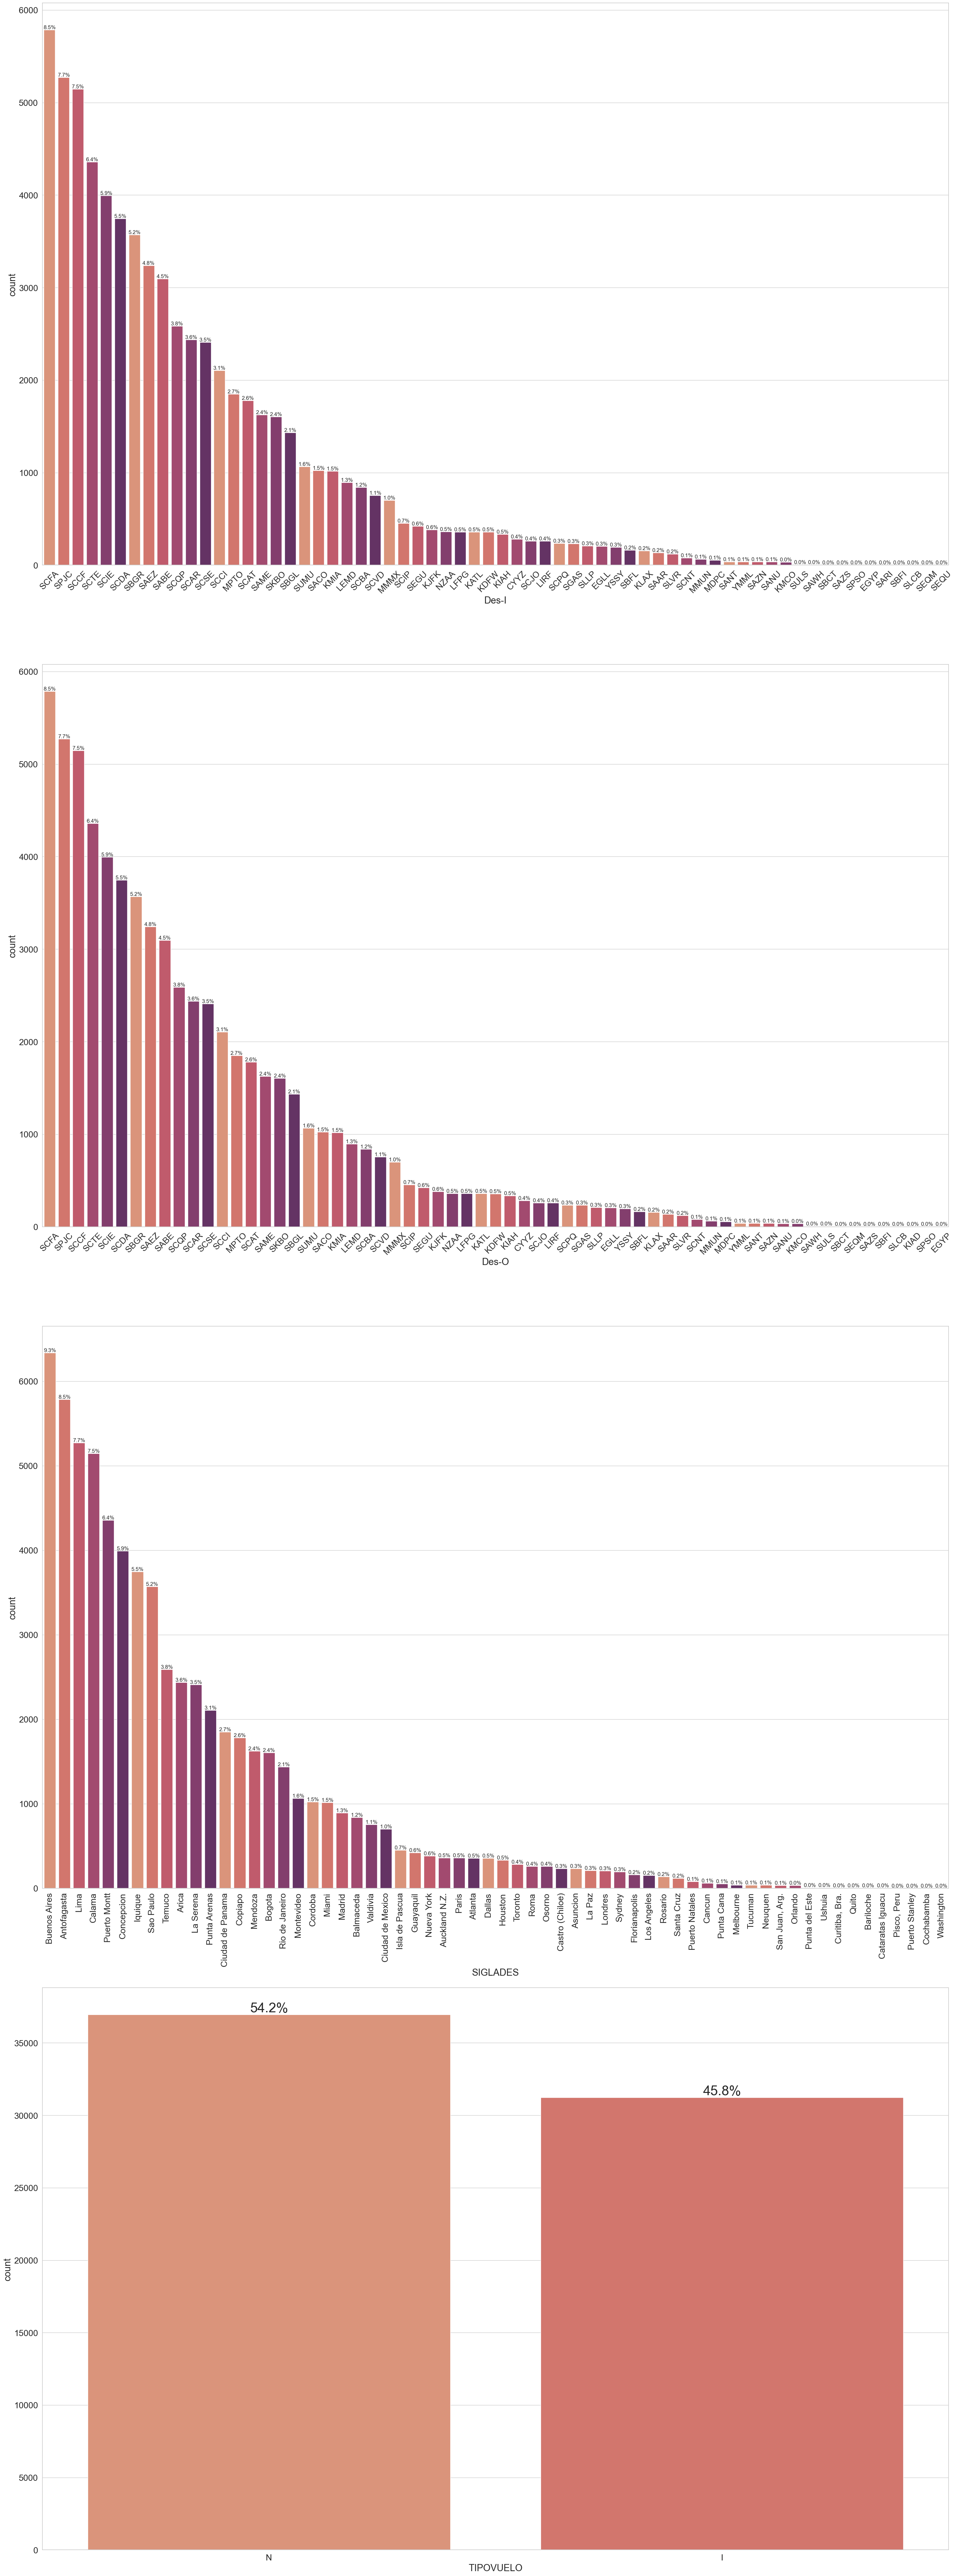

In [83]:
sns.set(rc={'figure.figsize':(30,80)})
sns.set_theme(style="whitegrid", font_scale=1.75)

categorical_vars = ['Des-I','Des-O','SIGLADES','TIPOVUELO']
plt.figure()
i = 0
for cat in categorical_vars:
    plt.subplot(len(categorical_vars), 1, 1 + i)
    ax = sns.countplot(data=df, x=cat,palette = sns.color_palette("flare"),order = df[cat].value_counts().index)
    if cat in ['Des-I','Des-O']: r, font_size = 45, 12
    elif cat in ['SIGLADES']: r, font_size = 90, 12
    else: r, font_size = 0, 30
    percentage_above_bar_relative_to_xgroup(ax,font_size)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=r)
    i += 1
plt.tight_layout()

Se observa que:
- Las distribuciones Des-I y Des-O son prácticamente idénticas, confirmando que los cambios de destino son excepcionales.
- Los principales destinos son las ciudades de Buenos Aires, Antofagasta, Lima y Calama.
- Los vuelos nacionales/internacionales corresponden al 54.2%/45.8% respectivamente.

## Pregunta 2
**Genera las columnas adicionales y luego expórtelas en un archivo synthetic_features.csv**
<br>

Se procede a crear temporada_alta.

In [8]:
df['verano'] = pd.Series(dtype = int)
verano_mask = (df['Fecha-I'] >= '2017-12-15') | (df['Fecha-I'] <= '2017-03-03')
df.loc[verano_mask,'verano'] = 1
df['verano'] = df['verano'].fillna(0)

df['invierno'] = pd.Series(dtype = int)
invierno_mask = (df['Fecha-I'] >= '2017-07-15') & (df['Fecha-I'] <= '2017-07-31')
df.loc[invierno_mask,'invierno'] = 1
df['invierno'] = df['invierno'].fillna(0)

df['dieciocho'] = pd.Series(dtype = int)
dieciocho_mask = (df['Fecha-I'] >= '2017-09-11') & (df['Fecha-I'] <= '2017-09-30')
df.loc[dieciocho_mask,'dieciocho'] = 1
df['dieciocho'] = df['dieciocho'].fillna(0)

df['temporada_alta'] = (df['verano'] + df['invierno'] + df['dieciocho']).astype('category')
df = df.drop(['verano','invierno','dieciocho'], axis = 1)

A continuación se construyen dif_min y atraso_15.

In [9]:
df['dif_min'] = (df['Fecha-O'] - df['Fecha-I']).dt.total_seconds().div(60).astype(int)
df['atraso_15'] = np.where(df['dif_min']>15, 1, 0)

Finalmente se crea periodo_dia.

In [10]:
labels = ['noche','mañana', 'tarde', 'noche']
df['periodo_dia'] = pd.cut(df['Fecha-I'].dt.hour,[0, 5, 12, 19, 24],labels=labels, ordered = False, right=False)


Se guarda el nuevo archivo y se verifican los tipos de datos.

In [85]:
df.to_csv('synthetic_features.csv')
df.dtypes

Fecha-I           datetime64[ns]
Vlo-I                   category
Ori-I                   category
Des-I                   category
Emp-I                   category
Fecha-O           datetime64[ns]
Vlo-O                   category
Ori-O                   category
Des-O                   category
Emp-O                   category
DIA                     category
MES                     category
AÑO                     category
DIANOM                  category
TIPOVUELO               category
OPERA                   category
SIGLAORI                category
SIGLADES                category
temporada_alta          category
dif_min                    int64
atraso_15                  int64
periodo_dia             category
dtype: object

La variable atraso_15 se deja como int64, a pesar de ser conceptualmente categórica. Esto se debe a que el tipo int64 facilita los cálculos de la tasa de atraso. Se asume la definición de tasa de atraso como el porcentaje de los vuelos que sufrieron atraso. Esto es equivalente al promedio de la columna atraso_15.
<br>

A continuación, se realiza una inspección rápida de las nuevas variables.

In [86]:
df[['temporada_alta','dif_min','atraso_15','periodo_dia']].describe(include='all',datetime_is_numeric=True)

,temporada_alta,dif_min,atraso_15,periodo_dia
count,68206.0,68206.000000,68206.000000,68206
unique,2.0,NaN,NaN,3
top,0.0,NaN,NaN,tarde
freq,45995.0,NaN,NaN,25506
mean,NaN,9.110855,0.184940,NaN
std,NaN,19.313387,0.388252,NaN
min,NaN,-14.000000,0.000000,NaN
25%,NaN,-1.000000,0.000000,NaN
50%,NaN,4.000000,0.000000,NaN
75%,NaN,12.000000,0.000000,NaN


Se concluye que:
- Ninguna variable nueva presenta datos faltantes.
- La tasa de atraso de todo el dataset es de 18.5%, por lo que el problema a resolver es de clasificación desbalanceada.

## Pregunta 3
**¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo
de vuelo?**
<br>

Para responder la pregunta, se procede a graficar la tasa de atraso por categoría. Se seleccionarán las categorías que puedan servir para la creación del modelo posterior. 
<br>

Por lo tanto, se desechan las variales tipo '-O', ya que se desconoce con cuánta anticipación se pueden obtener esos valores. Por ejemplo, un vuelo podría cambiar su Des-O por alguna emergencia una vez que ya ha despegado.

<br>

Por otro lado, se asumirá que la planificación de los vuelos ocurre con la antelación suficiente para permitir realizar las predicciones que se necesitan.

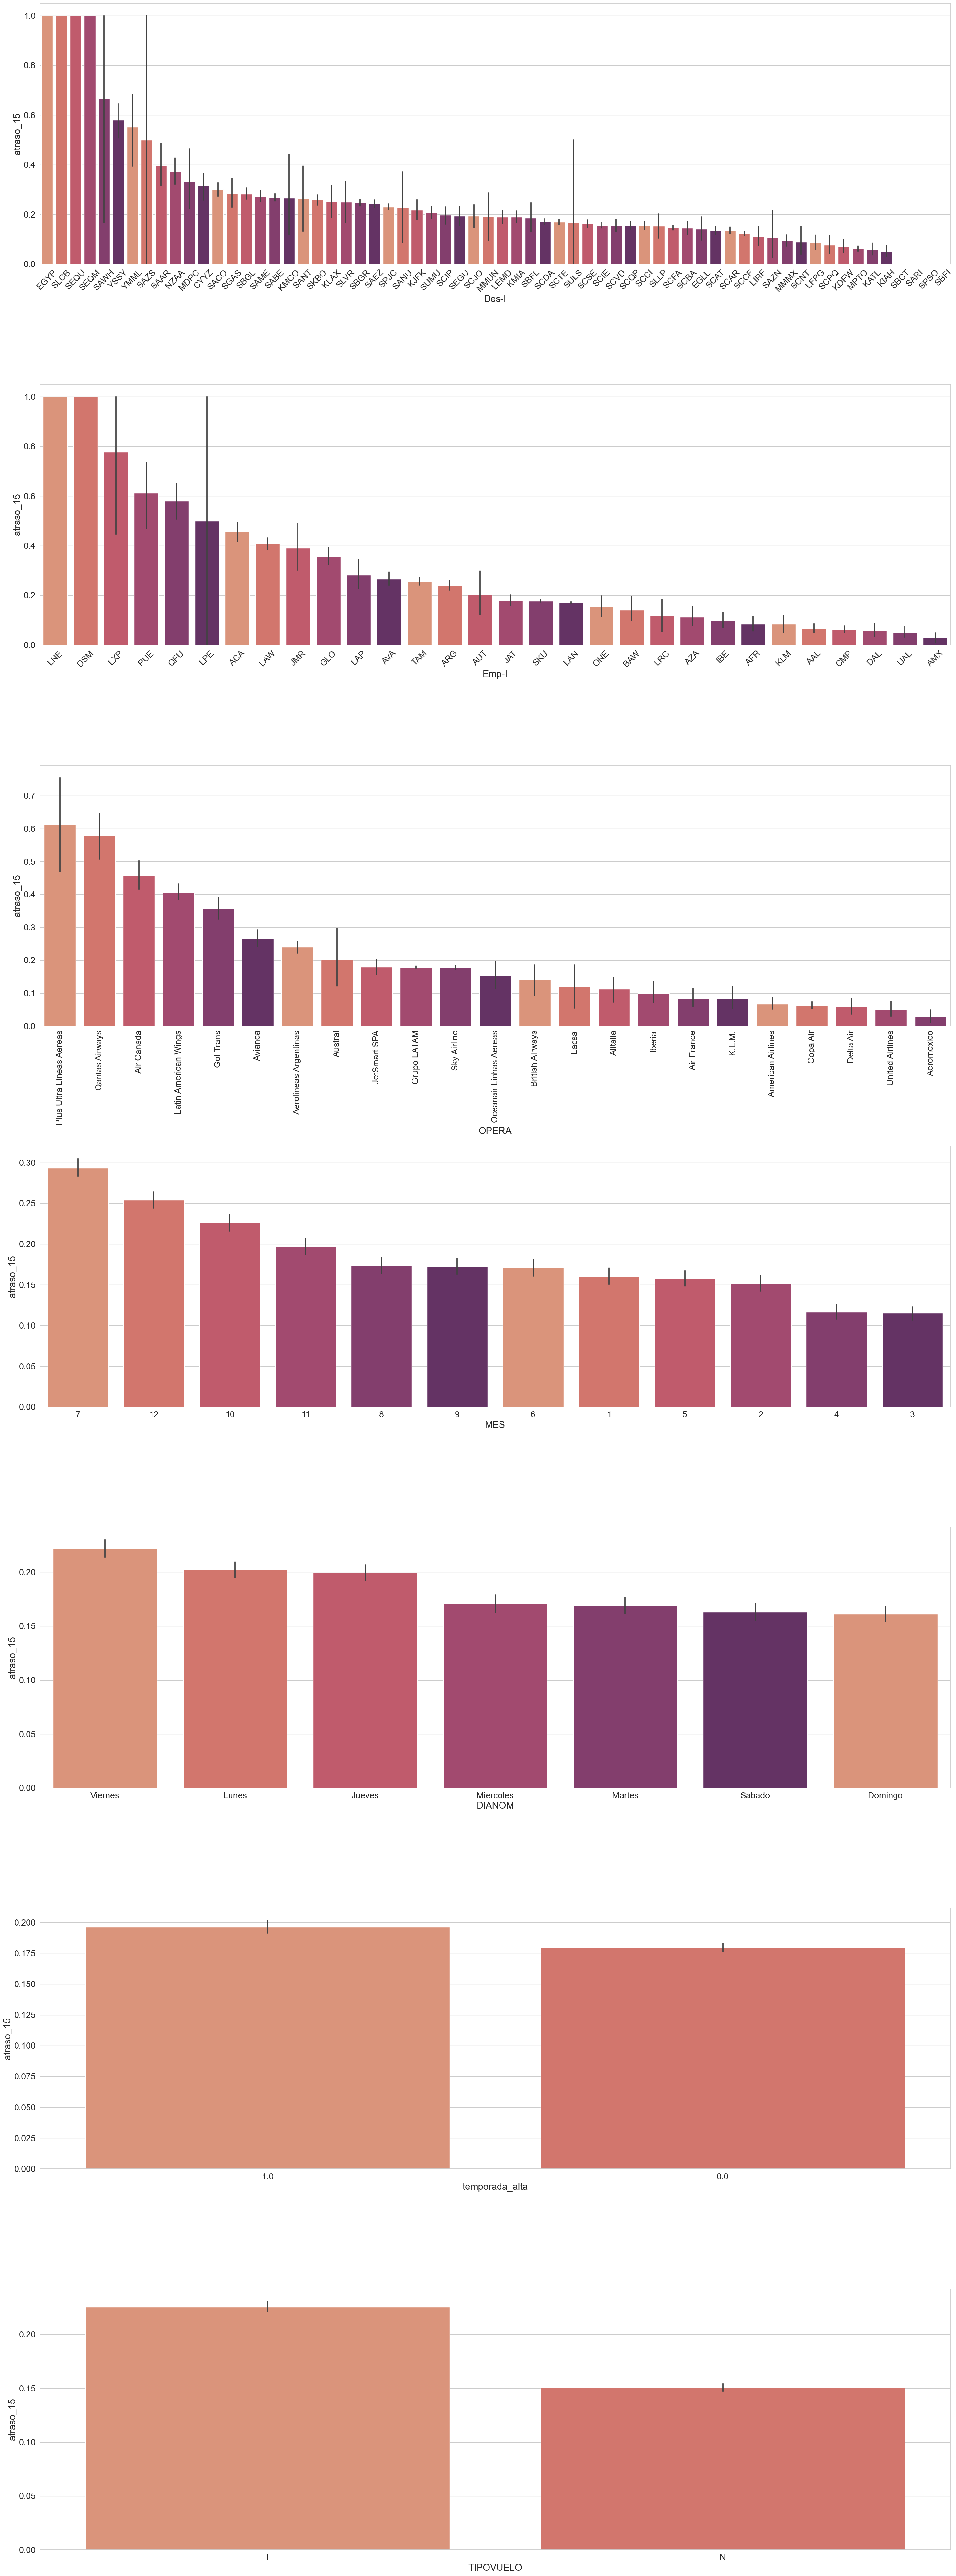

In [88]:
sns.set(rc={'figure.figsize':(30,80)})
sns.set_theme(style="whitegrid", font_scale=1.75)

_vars = ['Des-I','Emp-I','OPERA','MES','DIANOM','temporada_alta','TIPOVUELO']
plt.figure()
i = 0
for cat in _vars:
    plt.subplot(len(_vars), 1, 1 + i)
    order = pd.pivot_table(data=df, index = cat)['atraso_15'].sort_values(ascending=False).index
    ax = sns.barplot(data=df, x = cat, y = 'atraso_15', order = order, palette = sns.color_palette("flare"))
    if cat in ['Des-I','Emp-I']: r = 45
    elif cat in ['OPERA']: r = 90    
    else: r = 0
    ax.set_xticklabels(ax.get_xticklabels(),rotation=r)
    i += 1
plt.tight_layout()

**¿Qué variables esperarías que más influyeran en predecir atrasos?**
<br>

Aquellas variables que presentan distribuciones más alejadas de una homogénea, ya que dichas categorías entregan mayor información sobre la probabilidad de tener atrasos. Para este caso, serían:
- Des-I
- Emp-I
- OPERA
<br>

Sin embargo, Emp-I es una subcategoría de OPERA, dejando a ésta última redundante.

## Pregunta 4
**Entrena uno o varios modelos (usando el/los algoritmo(s) que prefieras) para estimar la probabilidad de atraso
de un vuelo. Siéntete libre de generar variables adicionales y/o complementar con variables externas.**
<br>

Una potencial causa de atrasos es la saturación del aeropuerto por alta cantidad de vuelos. Para capturar este efecto, se creará la variable num_vuelos, que corresponderá a la cuenta de vuelos planificados para una cierta fecha, en un cierto periodo del día, para un cierto tipo de vuelo.

In [90]:
df['num_vuelos'] = df.groupby(['MES','DIA','periodo_dia','TIPOVUELO'])['Vlo-I'].transform('count').astype(int)

df['num_vuelos'].describe()

count    68206.000000
mean        34.164942
std          9.153096
min          1.000000
25%         27.000000
50%         32.000000
75%         42.000000
max         58.000000
Name: num_vuelos, dtype: float64

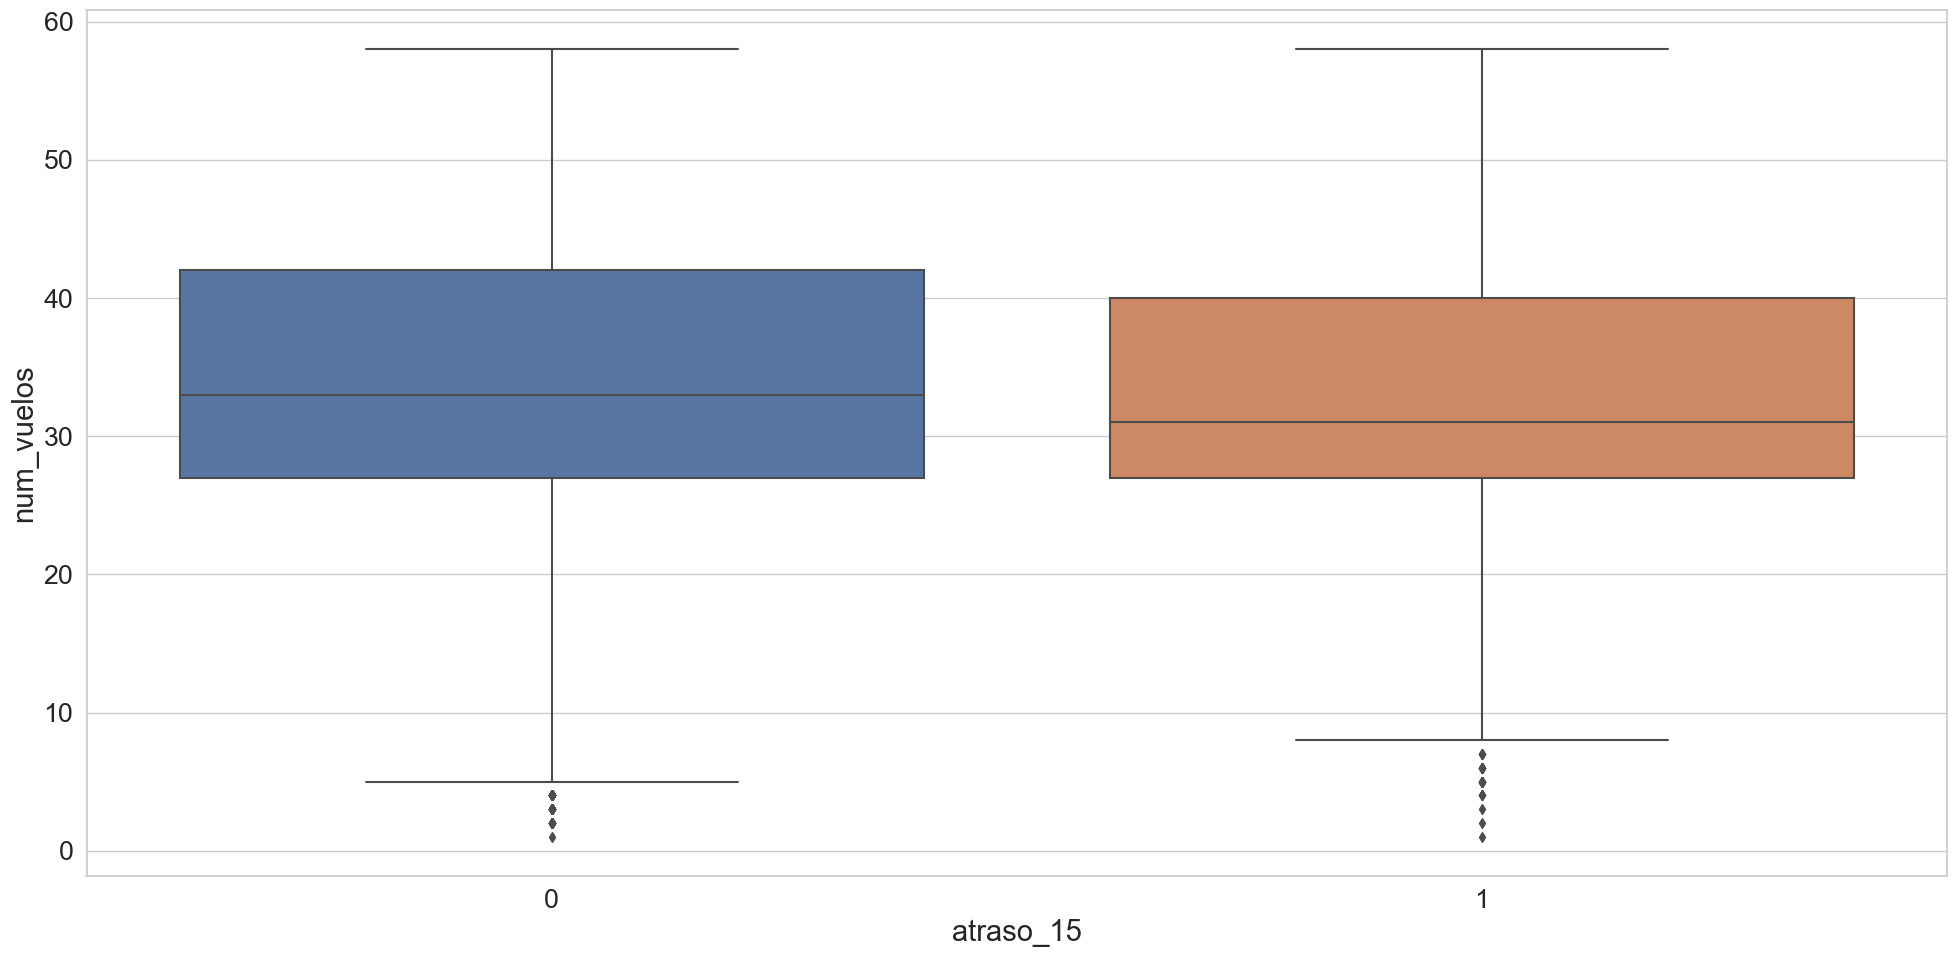

In [103]:
sns.set(rc={'figure.figsize':(20,10)})
sns.set_theme(style="whitegrid", font_scale=1.75)

sns.boxplot(data=df[['num_vuelos','atraso_15']], x='atraso_15', y='num_vuelos')
plt.tight_layout()

In [42]:
features = ['Des-I', 'Emp-I', 'DIA', 'MES', 'DIANOM', 'TIPOVUELO', 'temporada_alta', 'periodo_dia']
target = 'atraso_15'

x, x_test, y, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42, stratify=df[target])


grid = {'lambda':[0.5, 1 , 2]
        , 'alpha':[0, 0.5]
        , 'gamma':[0]
        , 'max_delta_step':[0, 1, 5]
        , 'n_estimators': [500]
        , 'learning_rate':[0.1, 0.3]
        , 'max_depth':[3,6]}

#grid = {'alpha': [0.5], 'gamma': [0], 'lambda': [0.5], 'learning_rate': [0.1], 'max_delta_step': [1], 'max_depth': [3]
#        , 'n_estimators': [1000, 2000], 'early_stopping': [20] }

_xgb = xgb.XGBClassifier(tree_method="hist", enable_categorical=True)
clf = GridSearchCV(_xgb, grid, cv = 5, verbose = 4, scoring='accuracy')
clf.fit(x, y)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END alpha=0, gamma=0, lambda=0.5, learning_rate=0.1, max_delta_step=0, max_depth=3, n_estimators=500;, score=0.822 total time=   1.7s
[CV 2/5] END alpha=0, gamma=0, lambda=0.5, learning_rate=0.1, max_delta_step=0, max_depth=3, n_estimators=500;, score=0.823 total time=   1.6s
[CV 3/5] END alpha=0, gamma=0, lambda=0.5, learning_rate=0.1, max_delta_step=0, max_depth=3, n_estimators=500;, score=0.823 total time=   1.7s
[CV 4/5] END alpha=0, gamma=0, lambda=0.5, learning_rate=0.1, max_delta_step=0, max_depth=3, n_estimators=500;, score=0.825 total time=   1.9s
[CV 5/5] END alpha=0, gamma=0, lambda=0.5, learning_rate=0.1, max_delta_step=0, max_depth=3, n_estimators=500;, score=0.823 total time=   1.8s
[CV 1/5] END alpha=0, gamma=0, lambda=0.5, learning_rate=0.1, max_delta_step=0, max_depth=6, n_estimators=500;, score=0.810 total time=   3.2s
[CV 2/5] END alpha=0, gamma=0, lambda=0.5, learning_rate=0.1, max_delta_step=0, 

[CV 3/5] END alpha=0, gamma=0, lambda=0.5, learning_rate=0.3, max_delta_step=5, max_depth=6, n_estimators=500;, score=0.793 total time=   3.5s
[CV 4/5] END alpha=0, gamma=0, lambda=0.5, learning_rate=0.3, max_delta_step=5, max_depth=6, n_estimators=500;, score=0.790 total time=   3.4s
[CV 5/5] END alpha=0, gamma=0, lambda=0.5, learning_rate=0.3, max_delta_step=5, max_depth=6, n_estimators=500;, score=0.798 total time=   3.4s
[CV 1/5] END alpha=0, gamma=0, lambda=1, learning_rate=0.1, max_delta_step=0, max_depth=3, n_estimators=500;, score=0.821 total time=   1.8s
[CV 2/5] END alpha=0, gamma=0, lambda=1, learning_rate=0.1, max_delta_step=0, max_depth=3, n_estimators=500;, score=0.822 total time=   2.0s
[CV 3/5] END alpha=0, gamma=0, lambda=1, learning_rate=0.1, max_delta_step=0, max_depth=3, n_estimators=500;, score=0.825 total time=   1.7s
[CV 4/5] END alpha=0, gamma=0, lambda=1, learning_rate=0.1, max_delta_step=0, max_depth=3, n_estimators=500;, score=0.826 total time=   1.8s
[CV 5/5

[CV 2/5] END alpha=0, gamma=0, lambda=1, learning_rate=0.3, max_delta_step=5, max_depth=6, n_estimators=500;, score=0.792 total time=   3.4s
[CV 3/5] END alpha=0, gamma=0, lambda=1, learning_rate=0.3, max_delta_step=5, max_depth=6, n_estimators=500;, score=0.796 total time=   3.6s
[CV 4/5] END alpha=0, gamma=0, lambda=1, learning_rate=0.3, max_delta_step=5, max_depth=6, n_estimators=500;, score=0.791 total time=   3.5s
[CV 5/5] END alpha=0, gamma=0, lambda=1, learning_rate=0.3, max_delta_step=5, max_depth=6, n_estimators=500;, score=0.798 total time=   3.4s
[CV 1/5] END alpha=0, gamma=0, lambda=2, learning_rate=0.1, max_delta_step=0, max_depth=3, n_estimators=500;, score=0.821 total time=   1.9s
[CV 2/5] END alpha=0, gamma=0, lambda=2, learning_rate=0.1, max_delta_step=0, max_depth=3, n_estimators=500;, score=0.823 total time=   1.8s
[CV 3/5] END alpha=0, gamma=0, lambda=2, learning_rate=0.1, max_delta_step=0, max_depth=3, n_estimators=500;, score=0.824 total time=   1.8s
[CV 4/5] END 

[CV 1/5] END alpha=0, gamma=0, lambda=2, learning_rate=0.3, max_delta_step=5, max_depth=6, n_estimators=500;, score=0.787 total time=   3.6s
[CV 2/5] END alpha=0, gamma=0, lambda=2, learning_rate=0.3, max_delta_step=5, max_depth=6, n_estimators=500;, score=0.794 total time=   3.5s
[CV 3/5] END alpha=0, gamma=0, lambda=2, learning_rate=0.3, max_delta_step=5, max_depth=6, n_estimators=500;, score=0.795 total time=   3.4s
[CV 4/5] END alpha=0, gamma=0, lambda=2, learning_rate=0.3, max_delta_step=5, max_depth=6, n_estimators=500;, score=0.791 total time=   3.5s
[CV 5/5] END alpha=0, gamma=0, lambda=2, learning_rate=0.3, max_delta_step=5, max_depth=6, n_estimators=500;, score=0.798 total time=   3.5s
[CV 1/5] END alpha=0.5, gamma=0, lambda=0.5, learning_rate=0.1, max_delta_step=0, max_depth=3, n_estimators=500;, score=0.821 total time=   1.8s
[CV 2/5] END alpha=0.5, gamma=0, lambda=0.5, learning_rate=0.1, max_delta_step=0, max_depth=3, n_estimators=500;, score=0.824 total time=   1.7s
[CV 3

[CV 3/5] END alpha=0.5, gamma=0, lambda=0.5, learning_rate=0.3, max_delta_step=5, max_depth=3, n_estimators=500;, score=0.823 total time=   1.8s
[CV 4/5] END alpha=0.5, gamma=0, lambda=0.5, learning_rate=0.3, max_delta_step=5, max_depth=3, n_estimators=500;, score=0.823 total time=   1.7s
[CV 5/5] END alpha=0.5, gamma=0, lambda=0.5, learning_rate=0.3, max_delta_step=5, max_depth=3, n_estimators=500;, score=0.820 total time=   1.9s
[CV 1/5] END alpha=0.5, gamma=0, lambda=0.5, learning_rate=0.3, max_delta_step=5, max_depth=6, n_estimators=500;, score=0.790 total time=   3.4s
[CV 2/5] END alpha=0.5, gamma=0, lambda=0.5, learning_rate=0.3, max_delta_step=5, max_depth=6, n_estimators=500;, score=0.796 total time=   3.4s
[CV 3/5] END alpha=0.5, gamma=0, lambda=0.5, learning_rate=0.3, max_delta_step=5, max_depth=6, n_estimators=500;, score=0.795 total time=   3.5s
[CV 4/5] END alpha=0.5, gamma=0, lambda=0.5, learning_rate=0.3, max_delta_step=5, max_depth=6, n_estimators=500;, score=0.798 tota

[CV 1/5] END alpha=0.5, gamma=0, lambda=1, learning_rate=0.3, max_delta_step=5, max_depth=3, n_estimators=500;, score=0.817 total time=   1.7s
[CV 2/5] END alpha=0.5, gamma=0, lambda=1, learning_rate=0.3, max_delta_step=5, max_depth=3, n_estimators=500;, score=0.818 total time=   1.8s
[CV 3/5] END alpha=0.5, gamma=0, lambda=1, learning_rate=0.3, max_delta_step=5, max_depth=3, n_estimators=500;, score=0.821 total time=   1.7s
[CV 4/5] END alpha=0.5, gamma=0, lambda=1, learning_rate=0.3, max_delta_step=5, max_depth=3, n_estimators=500;, score=0.820 total time=   1.6s
[CV 5/5] END alpha=0.5, gamma=0, lambda=1, learning_rate=0.3, max_delta_step=5, max_depth=3, n_estimators=500;, score=0.818 total time=   1.8s
[CV 1/5] END alpha=0.5, gamma=0, lambda=1, learning_rate=0.3, max_delta_step=5, max_depth=6, n_estimators=500;, score=0.787 total time=   3.5s
[CV 2/5] END alpha=0.5, gamma=0, lambda=1, learning_rate=0.3, max_delta_step=5, max_depth=6, n_estimators=500;, score=0.793 total time=   3.5s

[CV 4/5] END alpha=0.5, gamma=0, lambda=2, learning_rate=0.3, max_delta_step=1, max_depth=6, n_estimators=500;, score=0.796 total time=   3.6s
[CV 5/5] END alpha=0.5, gamma=0, lambda=2, learning_rate=0.3, max_delta_step=1, max_depth=6, n_estimators=500;, score=0.800 total time=   3.4s
[CV 1/5] END alpha=0.5, gamma=0, lambda=2, learning_rate=0.3, max_delta_step=5, max_depth=3, n_estimators=500;, score=0.815 total time=   1.8s
[CV 2/5] END alpha=0.5, gamma=0, lambda=2, learning_rate=0.3, max_delta_step=5, max_depth=3, n_estimators=500;, score=0.819 total time=   2.0s
[CV 3/5] END alpha=0.5, gamma=0, lambda=2, learning_rate=0.3, max_delta_step=5, max_depth=3, n_estimators=500;, score=0.819 total time=   1.8s
[CV 4/5] END alpha=0.5, gamma=0, lambda=2, learning_rate=0.3, max_delta_step=5, max_depth=3, n_estimators=500;, score=0.820 total time=   1.8s
[CV 5/5] END alpha=0.5, gamma=0, lambda=2, learning_rate=0.3, max_delta_step=5, max_depth=3, n_estimators=500;, score=0.819 total time=   1.9s

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=True, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, m...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                  

In [43]:
print('Best parameter: ',clf.best_params_)
print('Best score: ',clf.best_score_)
print('Best estimator: ',clf.best_estimator_)

Best parameter:  {'alpha': 0.5, 'gamma': 0, 'lambda': 0.5, 'learning_rate': 0.1, 'max_delta_step': 1, 'max_depth': 3, 'n_estimators': 500}
Best score:  0.8242247351285144
Best estimator:  XGBClassifier(alpha=0.5, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=0.5, learning_rate=0.1,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=1, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, ...)


In [44]:
y_pred = clf.predict(x_test)

print('Accuracy: ',accuracy_score(y_test,y_pred))

Accuracy:  0.8223134437765723


Mejoras
- Consultar directamente a cliente causas de atrasos
- Integrar información extra, api gps y clima
- Agregar mas años de datos
- Otros modelos